In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import time
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np


import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Some weights of BertForSequenceClassification were not initialized from the model")
warnings.filterwarnings("ignore", message="You should probably TRAIN this model on a down-stream task")

# Your code here
# Example:
# from transformers import BertForSequenceClassification
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Reset the warnings to default behavior after executing the code
warnings.resetwarnings()

2024-05-04 14:24:43.508879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [26]:
import os 
def get_model_size(model):
    """
    Get the size of the model in memory.
    """
    torch.save(model.state_dict(), 'temp_model.pth')
    model_size = os.path.getsize('temp_model.pth')  # Size of the serialized model in bytes
    os.remove('temp_model.pth')  # Remove the temporary file
    return model_size



In [27]:
def calculate_unable_params(model, optimizer):
    """
    Calculate the number of parameters that are unable to be updated during training.
    """
    trainable_params = set(p for p in model.parameters() if p.requires_grad)
    trainable_param_ids = set(id(p) for p in trainable_params)
    optimizer_param_ids = set(id(p) for group in optimizer.param_groups for p in group["params"])
    unable_params_ids = trainable_param_ids - optimizer_param_ids
    unable_params = sum(p.numel() for p in trainable_params if id(p) in unable_params_ids)
    return unable_params



In [28]:
def run_experiment(layer_name, layers_to_skip, num_samples, dataset_path="customer_support_tickets.csv"):
    print(f"\nRunning experiment: {layer_name}")
    
    # Load the dataset
    print("Loading dataset...")
    data = pd.read_csv(dataset_path)
    data = data.dropna(subset=['Ticket Description'])
    data = data[['Ticket Description', 'Ticket Type']]
    
    # Sample data if not using the full dataset
    if num_samples == "full":
        data_subset = data
    else:
        data_subset = data.sample(n=num_samples, random_state=42)
    
    # Split the data into train and test sets
    print("Splitting data into train and test sets...")
    train_texts, test_texts, train_labels, test_labels = train_test_split(data_subset['Ticket Description'], data_subset['Ticket Type'], test_size=0.2, random_state=42)
    
    # Encode labels
    print("Encoding labels...")
    label_encoder = LabelEncoder()
    train_labels_encoded = label_encoder.fit_transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    # Tokenization
    print("Tokenizing data...")
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
    test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)

    # Convert encodings to a format suitable for the trainer
    print("Converting encodings to PyTorch Dataset format...")
    class MyDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    train_dataset = MyDataset(train_encodings, train_labels_encoded)
    eval_dataset = MyDataset(test_encodings, test_labels_encoded)

    # Define BERT model
    print("Loading BERT model...")
    model_finetuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

    # Fine-tune by skipping intermediate layers
    if layers_to_skip == 'full':
        print("Not skipping any layers (training with all layers)...")
        model_pretrained = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    else:    
        print("Skipping specified layers...")
        encoder_layers = model_finetuned.bert.encoder.layer
        model_finetuned.bert.encoder.layer = torch.nn.ModuleList([layer for i, layer in enumerate(encoder_layers) if i in layers_to_skip])

        
    # Define training arguments
    print("Defining training arguments...")
    training_args = TrainingArguments(
        output_dir='./results_finetuned',
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        evaluation_strategy='epoch',
        logging_dir='./logs_finetuned',
        num_train_epochs=3,
        learning_rate=2e-5,
        save_strategy='epoch',
        load_best_model_at_end=True
    )

    # Define trainer
    print("Initializing trainer...")
    trainer = Trainer(
        model=model_finetuned,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )

    # Track initial CPU memory usage
    #initial_memory = psutil.virtual_memory().used

    # Train and evaluate model
    print("Training and evaluating model...")
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    # Predict test data
    print("Predicting test data...")
    start_time = time.time()
    preds = trainer.predict(eval_dataset)
    prediction_time = time.time() - start_time

    # Track final CPU memory usage
    #final_memory = psutil.virtual_memory().used

    # Calculate memory consumed during training
    #memory_consumed = final_memory - initial_memory

    # Calculate metrics
    print("Calculating metrics...")
    accuracy = accuracy_score(test_labels_encoded, preds.predictions.argmax(axis=1))
    precision = precision_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
    recall = recall_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')
    f1 = f1_score(test_labels_encoded, preds.predictions.argmax(axis=1), average='weighted')

    # Additional metrics for resource and efficiency comparison
    #model_size = sum(p.numel() for p in model_finetuned.parameters())# Inside the run_experiment function:
    model_size = get_model_size(model_finetuned)
    num_params = sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad)
    #unable_params = sum(p.numel() for p in model_finetuned.parameters() if p.requires_grad and p.grad is None)
    # Inside the run_experiment function:
    #unable_params = calculate_unable_params(model_finetuned, trainer.optimizer)

    # Print results
    print("Results for Layer:", layer_name)
    results_df = pd.DataFrame({
        'Layer Name': [layer_name], 
        'Accuracy': [accuracy], 
        'Precision': [precision], 
        'Recall': [recall], 
        'F1': [f1], 
        'Training Time': [training_time],
        'Prediction Time': [prediction_time],
        'Model Size': [model_size],
        'Number of Parameters': [num_params],
    })
    display(results_df)

    return results_df

In [31]:
# Example usage:
layers_to_skip = [
    np.random.choice(range(12), 6, replace=False),  # Random skipping
    np.random.choice(range(12), 6, replace=False),
    np.random.choice(range(12), 6, replace=False),
    [i for i in range(1, 12, 2)],  # Skipping odd layers
    [i for i in range(0, 12, 2)],  # Skipping even layers
    [1,2,3,4,5,6,7,8],
    [5,6,7,8,9,10,11],
    []  # No skipping (full pre-trained)
]
#num_samples = 'full'  # Specify the number of samples, or "full" for the full dataset
num_samples = 'full'
results_dfs = []
display(layers_to_skip)
sorted_layers_to_skip = [ sorted(layer.tolist()) if isinstance(layer,np.ndarray) else layer for layer in layers_to_skip ]
display(sorted_layers_to_skip)
# Run experiments for each configuration
for layers in sorted_layers_to_skip:
    if len(layers) == 0:
        name = "Full_Pretrained"
        layers = 'full'
    else:
        name = "Layer_" + "_".join([ str(layer) for layer in layers]) + "_Skipped"
    results_df = run_experiment(name, layers, num_samples)
    results_dfs.append(results_df)

# Combine results into a single DataFrame
combined_results = pd.concat(results_dfs, ignore_index=True)
print("\nCombined Results:")
display(combined_results)

[array([10,  9,  0,  8,  5,  2]),
 array([10,  9,  0,  8,  6,  3]),
 array([ 7,  4, 10,  3,  1,  6]),
 [1, 3, 5, 7, 9, 11],
 [0, 2, 4, 6, 8, 10],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9, 10, 11],
 []]

[[0, 2, 5, 8, 9, 10],
 [0, 3, 6, 8, 9, 10],
 [1, 3, 4, 6, 7, 10],
 [1, 3, 5, 7, 9, 11],
 [0, 2, 4, 6, 8, 10],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [5, 6, 7, 8, 9, 10, 11],
 []]


Running experiment: Layer_0_2_5_8_9_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.627500,1.613622
2,1.617600,1.610853
3,1.605200,1.612711


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_5_8_9_10_Skipped


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_5_8_9_10_Skipped,0.20307,0.201249,0.20307,0.145599,6439.692999,263.75943,267876775,66958853



Running experiment: Layer_0_3_6_8_9_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.626800,1.613622
2,1.618000,1.611240
3,1.609300,1.612937


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_3_6_8_9_10_Skipped


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.54209,258.725424,267876775,66958853



Running experiment: Layer_1_3_4_6_7_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.623000,1.610842
2,1.611800,1.610921
3,1.608300,1.610199


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_3_4_6_7_10_Skipped


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_3_4_6_7_10_Skipped,0.20366,0.084385,0.20366,0.074252,6432.36228,257.727197,267876775,66958853



Running experiment: Layer_1_3_5_7_9_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.620100,1.610638
2,1.613300,1.611136
3,1.604800,1.611019


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_3_5_7_9_11_Skipped


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_3_5_7_9_11_Skipped,0.20366,0.041477,0.20366,0.068919,6434.899003,256.654628,267876775,66958853



Running experiment: Layer_0_2_4_6_8_10_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.625800,1.613784
2,1.617800,1.611195
3,1.609600,1.613146


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_0_2_4_6_8_10_Skipped


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853



Running experiment: Layer_1_2_3_4_5_6_7_8_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.622200,1.611263
2,1.612800,1.610571
3,1.608500,1.609990


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_1_2_3_4_5_6_7_8_Skipped


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597



Running experiment: Layer_5_6_7_8_9_10_11_Skipped
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Skipping specified layers...
Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.626300,1.612049
2,1.618000,1.611035
3,1.611400,1.610169


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Layer_5_6_7_8_9_10_11_Skipped


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725



Running experiment: Full_Pretrained
Loading dataset...
Splitting data into train and test sets...
Encoding labels...
Tokenizing data...
Converting encodings to PyTorch Dataset format...
Loading BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Not skipping any layers (training with all layers)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/monu/opt/anaconda3/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Defining training arguments...
Initializing trainer...
Training and evaluating model...


Epoch,Training Loss,Validation Loss
1,1.619500,1.611432
2,1.610600,1.612773
3,1.607300,1.610887


Checkpoint destination directory ./results_finetuned/checkpoint-847 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-1694 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results_finetuned/checkpoint-2541 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Predicting test data...


Calculating metrics...


/Users/monu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for Layer: Full_Pretrained


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085



Combined Results:


,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
0,Layer_0_2_5_8_9_10_Skipped,0.203070,0.201249,0.203070,0.145599,6439.692999,263.759430,267876775,66958853
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.542090,258.725424,267876775,66958853
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6432.362280,257.727197,267876775,66958853
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6434.899003,256.654628,267876775,66958853
4,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853
5,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597
6,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725
7,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085


In [32]:
# Sort DataFrame based on F1 score
combined_results_sorted = combined_results.sort_values(by='F1', ascending=False)

In [33]:
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
7,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085
4,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853
0,Layer_0_2_5_8_9_10_Skipped,0.203070,0.201249,0.203070,0.145599,6439.692999,263.759430,267876775,66958853
5,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.542090,258.725424,267876775,66958853
6,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6432.362280,257.727197,267876775,66958853
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6434.899003,256.654628,267876775,66958853


In [34]:
# Sort DataFrame based on Accuracy score
combined_results_sorted = combined_results.sort_values(by='Accuracy', ascending=False)

In [35]:
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
5,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597
7,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085
4,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853
6,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6432.362280,257.727197,267876775,66958853
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6434.899003,256.654628,267876775,66958853
0,Layer_0_2_5_8_9_10_Skipped,0.203070,0.201249,0.203070,0.145599,6439.692999,263.759430,267876775,66958853
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.542090,258.725424,267876775,66958853


In [37]:
# Sort DataFrame based on Processing Time' score
combined_results_sorted = combined_results.sort_values(by='Training Time', ascending=False)
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
7,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085
5,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597
6,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.542090,258.725424,267876775,66958853
4,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853
0,Layer_0_2_5_8_9_10_Skipped,0.203070,0.201249,0.203070,0.145599,6439.692999,263.759430,267876775,66958853
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6434.899003,256.654628,267876775,66958853
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6432.362280,257.727197,267876775,66958853


In [38]:
combined_results_sorted = combined_results.sort_values(by='Prediction Time', ascending=False)
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters
7,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085
5,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597
6,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725
0,Layer_0_2_5_8_9_10_Skipped,0.203070,0.201249,0.203070,0.145599,6439.692999,263.759430,267876775,66958853
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.542090,258.725424,267876775,66958853
4,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6432.362280,257.727197,267876775,66958853
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6434.899003,256.654628,267876775,66958853


In [40]:
from datetime import timedelta
# Add a column for processing time in days, hours, minutes, and seconds format
combined_results_sorted['Training Time (Hours)'] = combined_results_sorted['Training Time'].apply(lambda x: str(timedelta(seconds=x)))

In [42]:
combined_results_sorted

,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters,Training Time (Hours)
7,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085,4:05:43.339755
5,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597,2:30:35.415472
6,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725,2:04:06.618386
0,Layer_0_2_5_8_9_10_Skipped,0.203070,0.201249,0.203070,0.145599,6439.692999,263.759430,267876775,66958853,1:47:19.692999
1,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.542090,258.725424,267876775,66958853,1:47:40.542090
4,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853,1:47:21.745052
2,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6432.362280,257.727197,267876775,66958853,1:47:12.362280
3,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6434.899003,256.654628,267876775,66958853,1:47:14.899003


In [46]:
combined_results_sorted.to_csv('Result_saved_May_5_2024_results.csv',index=False)

In [47]:
df_loaded = pd.read_csv('Result_saved_May_5_2024_results.csv')

In [48]:
df_loaded

,Layer Name,Accuracy,Precision,Recall,F1,Training Time,Prediction Time,Model Size,Number of Parameters,Training Time (Hours)
0,Full_Pretrained,0.210153,0.168557,0.210153,0.161918,14743.339755,512.270853,438023751,109486085,4:05:43.339755
1,Layer_1_2_3_4_5_6_7_8_Skipped,0.214286,0.140591,0.214286,0.134741,9035.415472,343.937769,324592455,81134597,2:30:35.415472
2,Layer_5_6_7_8_9_10_11_Skipped,0.206021,0.084025,0.206021,0.103972,7446.618386,300.349434,296234615,74046725,2:04:06.618386
3,Layer_0_2_5_8_9_10_Skipped,0.203070,0.201249,0.203070,0.145599,6439.692999,263.759430,267876775,66958853,1:47:19.692999
4,Layer_0_3_6_8_9_10_Skipped,0.201299,0.096439,0.201299,0.117623,6460.542090,258.725424,267876775,66958853,1:47:40.542090
5,Layer_0_2_4_6_8_10_Skipped,0.207792,0.158397,0.207792,0.158951,6441.745052,258.355101,267876775,66958853,1:47:21.745052
6,Layer_1_3_4_6_7_10_Skipped,0.203660,0.084385,0.203660,0.074252,6432.362280,257.727197,267876775,66958853,1:47:12.362280
7,Layer_1_3_5_7_9_11_Skipped,0.203660,0.041477,0.203660,0.068919,6434.899003,256.654628,267876775,66958853,1:47:14.899003


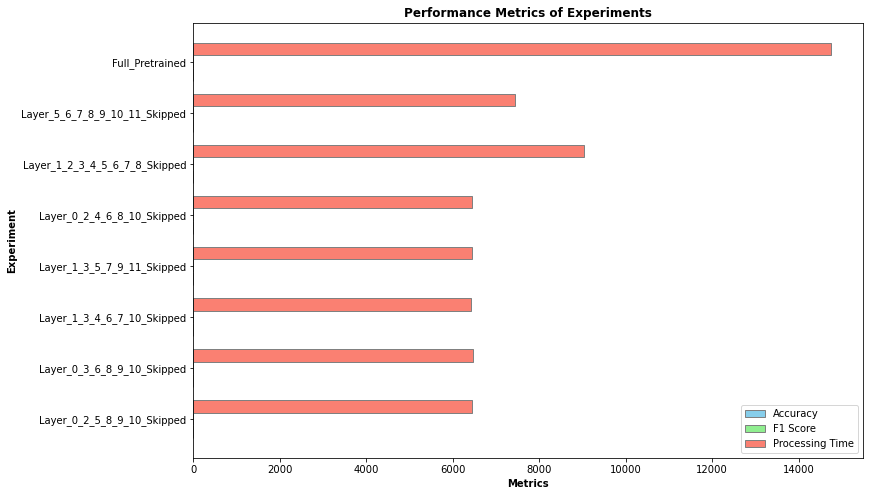

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the relevant data from the combined results DataFrame
experiment_names = combined_results['Layer Name']
accuracy = combined_results['Accuracy']
f1_score = combined_results['F1']
processing_time = combined_results['Training Time']

# Set the width of the bars
bar_width = 0.25

# Set the positions of the bars on the x-axis
r1 = np.arange(len(experiment_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the results
plt.figure(figsize=(12, 8))

plt.barh(r1, accuracy, color='skyblue', height=bar_width, edgecolor='grey', label='Accuracy')
plt.barh(r2, f1_score, color='lightgreen', height=bar_width, edgecolor='grey', label='F1 Score')
plt.barh(r3, processing_time, color='salmon', height=bar_width, edgecolor='grey', label='Processing Time')

# Add labels, tick labels, and title
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Experiment', fontweight='bold')
plt.yticks([r + bar_width for r in range(len(experiment_names))], experiment_names)
plt.title('Performance Metrics of Experiments', fontweight='bold')
plt.legend()

plt.show()
